# Automatically build the training set of annotated images

We want to automatically generate an annotated set of images with the TTA. The division events are spotted on the RFP images using a neural network. When an event is spotted, we take the first frame of happening, this is our starting frame $f$ at position $(x,y)$. We take a squared patch of the image, centered on $(x,y)$ of size $(2d, 2d)$ on a stack of frames, from $f - 8$ (arbitrary) to $f$. 

In [1]:
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from skimage.measure import find_contours # to get contours from masks
from skimage.filters import threshold_otsu

# btrack module and configuration file
import btrack
from btrack.dataio import localizations_to_objects
from btrack.constants import BayesianUpdates
from btrack.render import plot_tracks

import imagecodecs
import napari

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


# 1. Get the contours

<ipython-input-28-8681c2e32fba>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours = np.array(contours)


(75,)


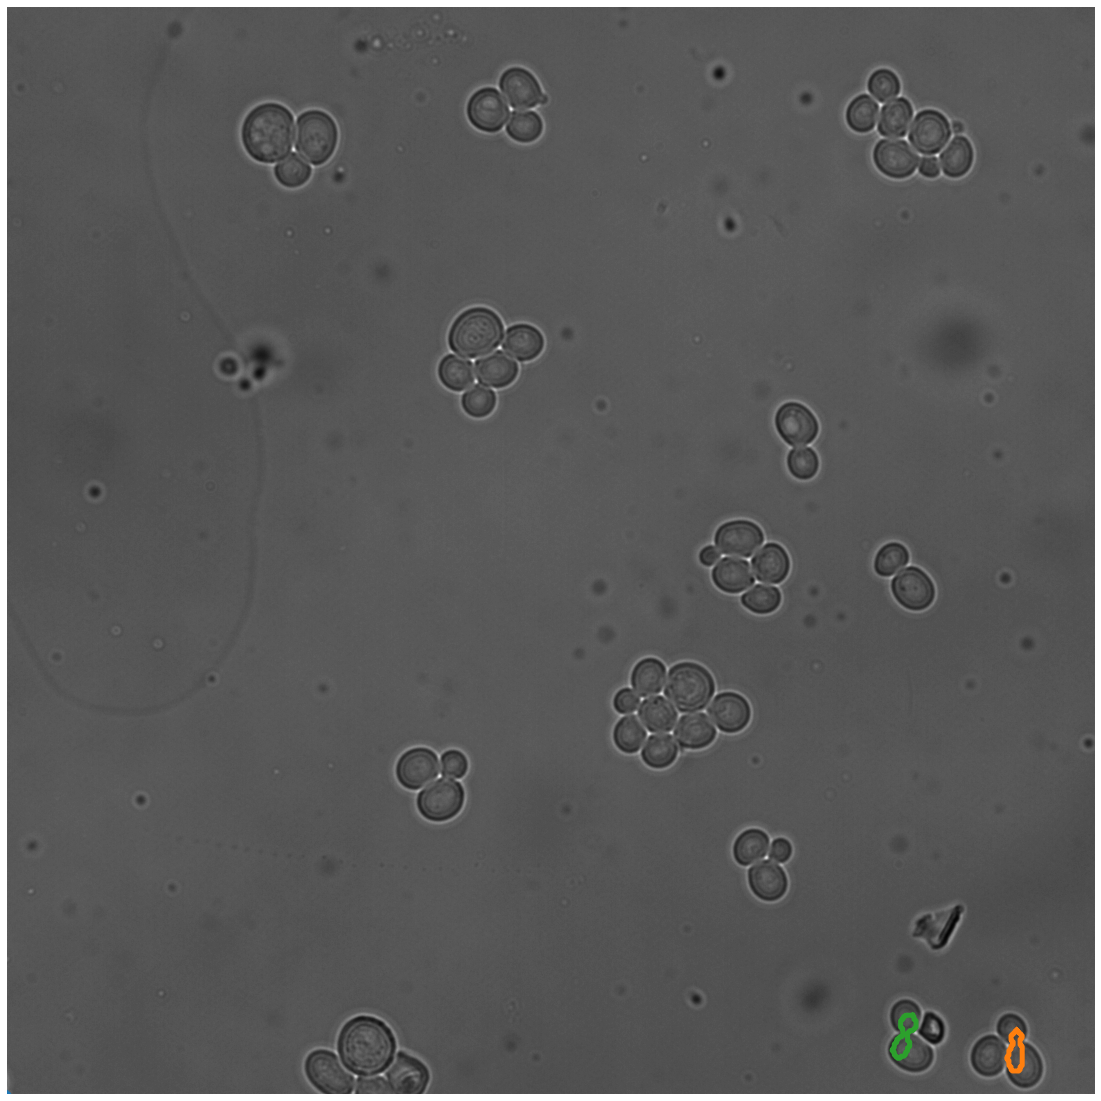

In [28]:
# load images and divided nuclei
os.chdir("D:/Hugo/Anaphase/DL")  # root dir containg Predictions and Images Path

bf_imgs = imageio.volread("BF_f0001-1-75.tif") # bf images
division_masks = imageio.volread("RFP_divisions_masks_1-75.tif") # rfp images

thresh = threshold_otsu(division_masks)
binary_masks = division_masks > thresh

# get the contours with skimage
contours = []
for im in binary_masks:
    contour = find_contours(im, level=(np.max(im) + np.min(im)) / 2) # list of (nx2) arrays, each array is a contour
    contours.append(contour)
contours = np.array(contours)

print(contours.shape)

plot_contours = True
if plot_contours:
    import matplotlib.colors as mcolors
    by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                             name) for name, color in mcolors.TABLEAU_COLORS.items()]
    names = [name for hsv, name in by_hsv]

    nb_imgs = 1
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))

    for i, (contour_im, im) in enumerate(zip(contours[10:11], bf_imgs[10:11])):
        ax.imshow(im, cmap="gray", origin="lower")
        for i, contour in enumerate(contour_im):
            ax.plot(contour[:, 1], contour[:, 0], linewidth=5, c=names[i % len(names)])
        ax.axis("off")

# 2. Perform tracking of the dividing nuclei and retrieve their position

(493, 5)


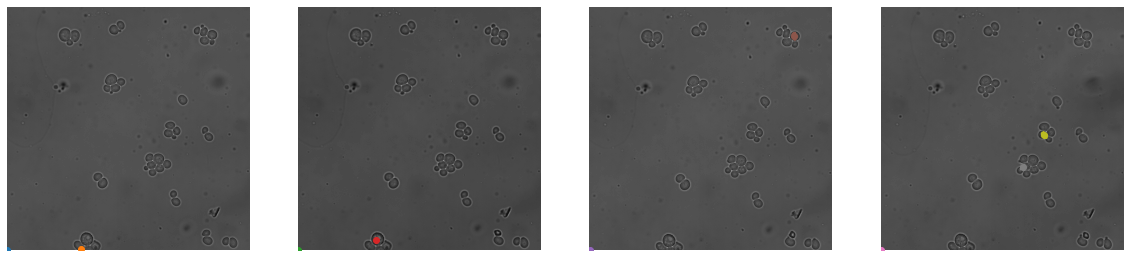

In [37]:
time_step = 6  # one image per 6 minutes

# retrieve all barycenters and shape a datastructure for btrack
positions_at_frames = []
for i, frame in enumerate(contours):
    for cell in frame:
        positions_at_frames.append({"t": i, "time": i * time_step, "x": np.sum(cell[:, 1]) / cell.shape[0], "y": np.sum(cell[:, 0]) / cell.shape[0], "contours": cell})
positions_per_frame = pd.DataFrame(positions_at_frames)

# check the shape
print(positions_per_frame.shape)

# Display the image and plot the barycenters to check if they're correct
import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name) for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]
nb_imgs = 4
fig, ax = plt.subplots(1, nb_imgs, figsize=(20, 20))

for i, (contour_im, im) in enumerate(zip(contours[:nb_imgs], bf_imgs[:nb_imgs])):
    ax[i].imshow(im, cmap="gray", origin="lower")
    for cont, (idx, cell) in zip(contour_im, positions_per_frame[positions_per_frame["t"] == i].iterrows()):
        x, y = cell["x"], cell["y"]
        ax[i].scatter(x, y, c=names[idx% len(names)])
        ax[i].plot(cont[:, 1], cont[:, 0], c=names[idx % len(names)])
    ax[i].axis("off")

### Run position-based tracking with btrack

In [44]:
import time

# os.chdir("D:/Hugo/Python_Scripts/Notebooks")
MODE = BayesianUpdates.EXACT # APPROXIMATE or EXACT
objects = localizations_to_objects(positions_per_frame)
objects[0]

t0 = time.time()

# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file (example config file used here)
  tracker.configure_from_file("Data/config_file.json")

  # set the update method and maximum search radius (both optional)
  tracker.update_method = MODE
  tracker.max_search_radius = 200

  # append the objects to be tracked
  tracker.append(objects)

  # set the volume (Z axis volume is set very large for 2D data)
  tracker.volume=((0,600),(0,800),(-1e5,1e5))

  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)

  # generate hypotheses and run the global optimiser
  tracker.optimize()

  # get the tracks as a python list
  tracks = tracker.tracks
  box = tracker.volume
    
tf = time.time()
print(f"Tracking duration : {round(tf - t0, 2)} seconds.")

[INFO][2021/04/29 09:21:03 AM] Objects are of type: <class 'pandas.core.frame.DataFrame'>
[INFO][2021/04/29 09:21:03 AM] Loaded btrack: C:\ProgramData\Anaconda3\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2021/04/29 09:21:03 AM] btrack (v0.4.0) library imported
[INFO][2021/04/29 09:21:03 AM] Setting max XYZ search radius to: 100
[INFO][2021/04/29 09:21:03 AM] Starting BayesianTracker session
[INFO][2021/04/29 09:21:03 AM] Loading configuration file: config_file.json
[INFO][2021/04/29 09:21:03 AM] Loading motion model: b'cell_motion'
[INFO][2021/04/29 09:21:03 AM] Setting Bayesian update method to: BayesianUpdates.EXACT
[INFO][2021/04/29 09:21:03 AM] Setting max XYZ search radius to: 200
[INFO][2021/04/29 09:21:03 AM] Objects are of type: <class 'list'>
[INFO][2021/04/29 09:21:03 AM] Set volume to ((0, 600), (0, 800), (-100000.0, 100000.0))
[INFO][2021/04/29 09:21:03 AM] Starting tracking... 
[INFO][2021/04/29 09:21:03 AM] Tracking objects in frames 0 to 75 (of 75)...
[INFO][202

Tracking duration : 0.08 seconds.


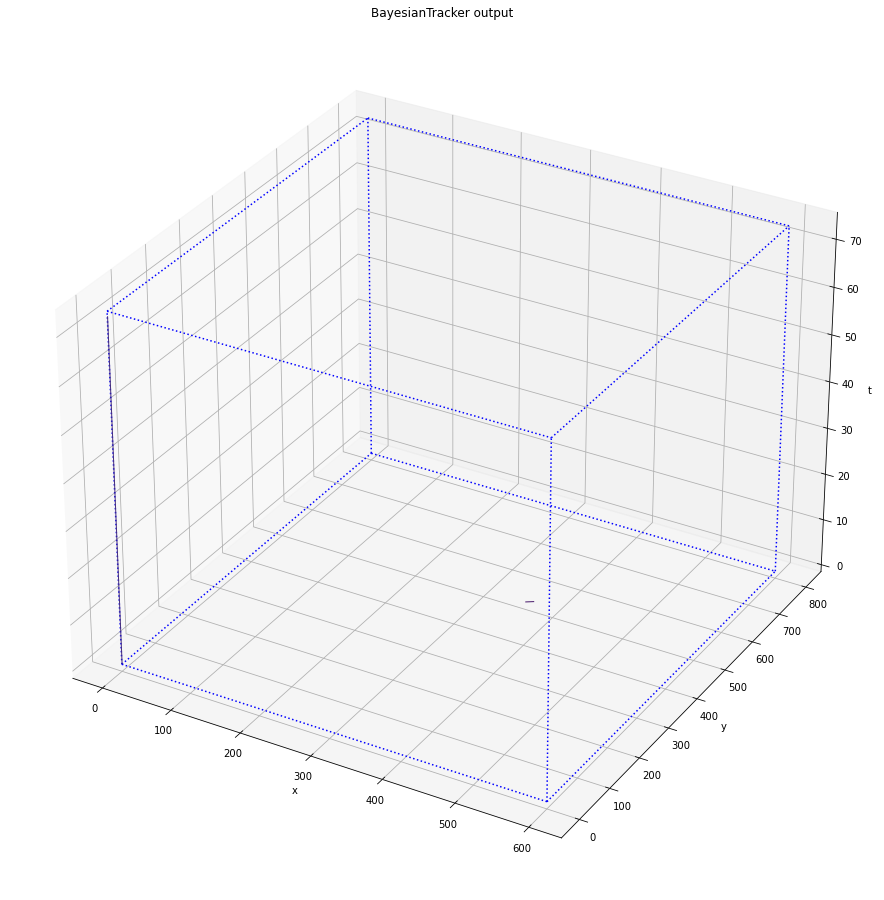

In [45]:
# plot the tracks in 3D
plot_tracks(tracks, order='xyt', box=box)

### Interactive view of the tracking results with napari

In [43]:
# Convert from the btrack format (data structure == OrderedDict) into a format that is accepted by Napari (i.e. numpy array)
tracks_to_napari = []
for track in tracks:
    for i, frame in enumerate(track.t):
        tracks_to_napari.append({"ID": track.ID, "Frame": frame, "X": track.y[i], "Y": track.x[i]})
tracks_to_napari = pd.DataFrame(tracks_to_napari)

print(tracks_to_napari.shape)
print(tracks_to_napari[:10])

with napari.gui_qt():
    viewer = napari.view_image(bf_imgs)
    viewer.add_tracks(tracks_to_napari)

(492, 4)
   ID  Frame     X     Y
0   2      0  0.25  0.25
1   2      1  0.25  0.25
2   2      2  0.25  0.25
3   2      3  0.25  0.25
4   2      4  0.25  0.25
5   2      5  0.25  0.25
6   2      6  0.25  0.25
7   2      7  0.25  0.25
8   2      8  0.25  0.25
9   2      9  0.25  0.25


NameError: name 'imgs' is not defined